## Chapter 3: Solving Problems by Searching

> In which we see how an agent can find a sequence of actions that achieves goals when no single action will do.

If you imagine a vacuuming robot whose performance is measured by the cleanliness of the floor at each given time step, it's easy to work out what to do in any given moment. If the floor is dirty you suck up all the dirt, and if the floor is clean then you move to a new square and repeat the process. Each immediate action has a value that you can determine since it's simple to see how each choice you make will impact the performance measure.

But what do you do when you have several options for action that have _unknown value_? How do you decide what steps you should take? An example of this would be trying to drive from one town to another; there's many different possible paths you can take and it's not clear which one will put you in the best position.

Searching is the solution to this -- exploring different combinations of actions in order to find the one that works best (or to find any solution at all in a reasonable amount of time).

There's two main types of searches:

* Uninformed searches, which have no knowledge other than the description of the problem.
* Informed searches, which can make use of specialised information (heurisitics) to better optimise what to search first.



### Trees, Graphs and Queues

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import queue

# --- Utilities --- #

# Normal queue.Queue doesn't have a way of checking if an item is in the queue.
# See https://stackoverflow.com/questions/16506429/check-if-element-is-already-in-a-queue
class Queue(queue.Queue): # or OrderedSetQueue
    def __contains__(self, item):
        with self.mutex:
            return item in self.queue
        
class PriorityQueue(queue.PriorityQueue): # or OrderedSetQueue
    def __contains__(self, item):
        with self.mutex:
            return item in self.queue
        
class LifoQueue(queue.LifoQueue): # or OrderedSetQueue
    def __contains__(self, item):
        with self.mutex:
            return item in self.queue
        
# solution finds the action sequence to achieve a goal state by unwinding from the goal node.
# Recursion!
def solution(g, initial, end):
    if initial == end:
        return []
    
    predecessors = [x for x in g.predecessors(end)]
    
    if len(predecessors) == 0:
        return []
    
    return solution(g, initial, predecessors[0]) + predecessors

In [2]:
# Example state space where 'I' is the initial state.
G = nx.DiGraph()

G.add_node("I")

G.add_node("A")
G.add_edge("I", "A", cost=1)

G.add_node("B")
G.add_edge("I", "B", cost=1)

G.add_node("C")
G.add_edge("A", "C", cost=1)
G.add_edge("C", "I", cost=1)

G.add_node("D")
G.add_edge("B", "D", cost=1)
G.add_node("E")
G.add_edge("B", "E", cost=1)

G.add_node("F")
G.add_node("G")
G.add_edge("E", "F", cost=1)
G.add_edge("E", "G", cost=1)

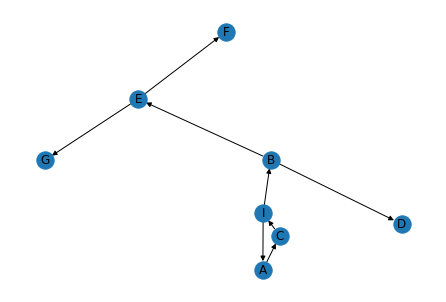

In [3]:
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos, with_labels=True)

In [4]:
# solution finds the action sequence to achieve a goal state by unwinding from the goal node.
def solution(g, initial, end):
    predecessors = [x for x in g.predecessors(end)]
    
    if initial == end:
        return []
    
    if len(predecessors) == 0:
        return actions
    
    return solution(g, initial, predecessors[0]) + predecessors

# breadth_first_search uses the breadth-first search strategy in order to find a goal node in state space.
# This means choosing the shallowest unexpanded node to expand first.
# It will return the list of nodes you have to go through in order to reach the goal.
def breadth_first_search(g, initial, goal):
    if initial == goal:
        return []
    
    node = initial
    
    frontier = Queue()
    frontier.put(node)
    
    explored = set()
    
    while not frontier.empty():
        node = frontier.get()
        explored.add(node)
        
        # If all the possible actions weren't already in the state space and we had a transition model,
        # we'd instead have to do something like problem.get_actions(node) and iterate through each action,
        # apply the transition model and see what state we end up in.
        # All the possible actions are already in our state space, so we don't have to do that here.
        for child in g.successors(node):
            if not (child in explored or child in frontier):
                if child == goal:
                    return solution(g, initial, child)

                frontier.put(child)
        
    return False
    

In [5]:
breadth_first_search(G, "I", "C")

['I', 'A']

In [6]:
# This was the actual classwork:
fibonacci = lambda x: 0 if x == 0 else 1 if x == 1 else 1 if x == 2 else fibonacci(x - 2) + fibonacci(x - 1)
fibonacci(7)

13

### Let's Class-ify Everything!
Search algorithms and problem solving follow steps that only change slightly depending on the search algorithm being used. We can make things a lot more general by using classes.

In [7]:
# Problem represents a general description of a problem.
# To define a problem you need 6 things:
# - An initial state
# - A description of the possible actions in a given state (get_actions)
# - A transition model that tells you what an action does in a state (get_successor)
# - A goal test that evaluates a state to see if it achieves the goal (is_goal)
# - A path cost function that assigns a numeric cost to any path is state space (path_cost)
class Problem:
    def __init__(self, initial):
        self.initial = initial
    
    def get_actions(self, state):
        raise NotImplementedError
        
    # This is the "transition model". In any state, we want to know what applying a certain action will do.
    def get_successor(self, state, action):
        raise NotImplementedError
        
    def step_cost(self, states):
        raise NotImplementedError
        
    def is_goal(self, state):
        raise NotImplementedError

# SimpleGraphProblem represents any problem where the potential actions in different states are already described in a graph.
class SimpleGraphProblem(Problem):
    def __init__(self, graph, initial, goal):
        super(Problem, self).__init__()
        self.graph = graph
        self.initial = initial
        self.goal = goal
        
    def get_actions(self, state):
        return self.graph.successors(state)
    
    def get_successor(self, state, action):
        return action
    
    def step_cost(self, state, successor):
        return self.graph.get_edge_data(state, successor).get("cost")
    
    def is_goal(self, state):
        return state == self.goal

class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
     
    def __repr__(self):
        return f"Node({self.state})"
    
def child_node(problem, parent, action):
    successor = problem.get_successor(parent.state, action)
    
    return Node(
        successor,
        parent,
        action,
        parent.path_cost + problem.step_cost(parent.state, successor)
    )
        
def solution(node):
    if node.parent == None:
        return []
    
    return solution(node.parent) + [node]

In [8]:
def breadth_first_search(problem):
    node = Node(state=problem.initial, path_cost=0)
    
    if problem.is_goal(node.state):
        return solution(node)
    
    frontier = Queue()
    frontier.put(node)
    
    explored = set()
    
    while not frontier.empty():
        node = frontier.get()
        explored.add(node.state)
        
        for action in problem.get_actions(node.state):
            child = child_node(problem, node, action)
            
            if not (child.state in explored or child in frontier):
                if problem.is_goal(child.state):
                    return solution(child)
                
                frontier.put(child)
                
    return False

In [9]:
# "Starting in state I, what path gets you to x for the graph G?"
graph_problem = SimpleGraphProblem(G, "I", "G")

# Breadth-first search will find the shallowest solution in state space. Since the toy graph G has uniform costs, the shallowest
# solution will be the optimal one.
breadth_first_search(graph_problem)

[Node(B), Node(E), Node(G)]

The following map comes from Figure 3.2:

![romania map](./media/romania.png)

{'Arad': array([0.23546029, 0.84987526]), 'Zerind': array([0.3574846, 0.620066 ]), 'Oradea': array([0.34279099, 0.36342777]), 'Timisoara': array([0.00226296, 0.96777375]), 'Sibiu': array([0.19629767, 0.15174386]), 'Lugoj': array([-0.24411312,  0.88139569]), 'Mehadia': array([-0.39253686,  0.66736176]), 'Drobeta': array([-0.41075754,  0.41094436]), 'Rimnicu Vilcea': array([-0.05306178,  0.16285921]), 'Craiova': array([-0.28772914,  0.18993559]), 'Fagaras': array([ 0.18238406, -0.10473709]), 'Pitesti': array([-0.18187546, -0.02750968]), 'Bucharest': array([-0.04894772, -0.24727056]), 'Giurgiu': array([-0.30026264, -0.31739865]), 'Urziceni': array([ 0.0020741 , -0.50996218]), 'Hirsova': array([-0.18453332, -0.69849096]), 'Eforie': array([-0.35393586, -0.87459858]), 'Vaslui': array([ 0.21218755, -0.65893176]), 'Iasi': array([ 0.38570252, -0.8264838 ]), 'Neamt': array([ 0.54110869, -1.        ])}


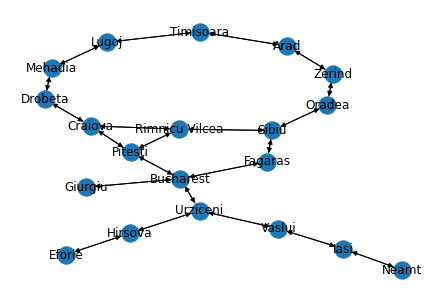

In [39]:
romania = nx.DiGraph()

romania_nodes = {
    "Arad": (),
    "Zerind": (),
    "Oradea": (),
    "Timisoara": (),
    "Sibiu": (),
    "Lugoj": (),
    "Mehadia": (),
    "Drobeta": (),
    "Rimnicu Vilcea": (),
    "Craiova": (),
    "Fagaras": (),
    "Pitesti": (),
    "Bucharest": (),
    "Giurgiu": (),
    "Urziceni": (),
    "Hirsova": (),
    "Eforie": (),
    "Vaslui": (),
    "Iasi": (),
    "Neamt": (),
}

romania.add_nodes_from([
    
])

romania.add_edges_from([
    ("Arad", "Zerind", {"cost": 75}),
    ("Zerind", "Arad", {"cost": 75}),
    
    ("Arad", "Timisoara", {"cost": 118}),
    ("Timisoara", "Arad", {"cost": 118}),
    
    ("Zerind", "Oradea", {"cost": 71}),
    ("Oradea", "Zerind", {"cost": 71}),
    
    ("Oradea", "Sibiu", {"cost": 151}),
    ("Sibiu", "Oradea", {"cost": 151}),
    
    ("Timisoara", "Lugoj", {"cost": 111}),
    ("Lugoj", "Timisoara", {"cost": 111}),
    
    ("Sibiu", "Fagaras", {"cost": 99}),
    ("Fagaras", "Sibiu", {"cost": 99}),
    
    ("Sibiu", "Rimnicu Vilcea", {"cost": 80}),
    ("Rimnicu Vilcea", "Sibiu", {"cost": 80}),
    
    ("Lugoj", "Mehadia", {"cost": 70}),
    ("Mehadia", "Lugoj", {"cost": 70}),
    
    ("Mehadia", "Drobeta", {"cost": 75}),
    ("Drobeta", "Mehadia", {"cost": 75}),
    
    ("Drobeta", "Craiova", {"cost": 120}),
    ("Craiova", "Drobeta", {"cost": 120}),
    
    ("Rimnicu Vilcea", "Pitesti", {"cost": 97}),
    ("Pitesti", "Rimnicu Vilcea", {"cost": 97}),
    
    ("Craiova", "Rimnicu Vilcea", {"cost": 146}),
    ("Rimnicu Vilcea", "Craiova", {"cost": 146}),
    
    ("Craiova", "Pitesti", {"cost": 138}),
    ("Pitesti", "Craiova", {"cost": 138}),
    
    ("Fagaras", "Bucharest", {"cost": 211}),
    ("Bucharest", "Fagaras", {"cost": 211}),
    
    ("Pitesti", "Bucharest", {"cost": 101}),
    ("Bucharest", "Pitesti", {"cost": 101}),
    
    ("Bucharest", "Giurgiu", {"cost": 90}),
    ("Giurgiu", "Bucharest", {"cost": 90}),
    
    ("Bucharest", "Urziceni", {"cost": 85}),
    ("Urziceni", "Bucharest", {"cost": 85}),
    
    ("Urziceni", "Hirsova", {"cost": 98}),
    ("Hirsova", "Urziceni", {"cost": 98}),
    
    ("Urziceni", "Vaslui", {"cost": 142}),
    ("Vaslui", "Urziceni", {"cost": 142}),
    
    ("Hirsova", "Eforie", {"cost": 86}),
    ("Eforie", "Hirsova", {"cost": 86}),
    
    ("Vaslui", "Iasi", {"cost": 92}),
    ("Iasi", "Vaslui", {"cost": 92}),
    
    ("Iasi", "Neamt", {"cost": 87}),
    ("Neamt", "Iasi", {"cost": 87}),
])

pos = nx.kamada_kawai_layout(romania)
nx.draw(romania, pos, with_labels=True)

In [27]:
def gen_color_map(G, initial, goal, actions):
    actions = [x.state for x in actions]
    colors = []
    for node in G:
        if node == initial or node == goal:
            colors.append("green")
        elif node in actions:
            colors.append("red")
        else:
            colors.append("blue")
    
    return colors

def display_path(G, problem, actions):
    if actions == False or actions == "cutoff":
        print("actions ->", actions)
        return
    
    print(" -> ".join([x.__repr__() for x in actions]))

    nx.draw(G, pos, with_labels=True, node_color=gen_color_map(G, problem.initial, problem.goal, actions))

CPU times: user 225 µs, sys: 62 µs, total: 287 µs
Wall time: 291 µs
Node(Zerind) -> Node(Oradea) -> Node(Sibiu) -> Node(Fagaras) -> Node(Bucharest) -> Node(Urziceni) -> Node(Vaslui) -> Node(Iasi) -> Node(Neamt)


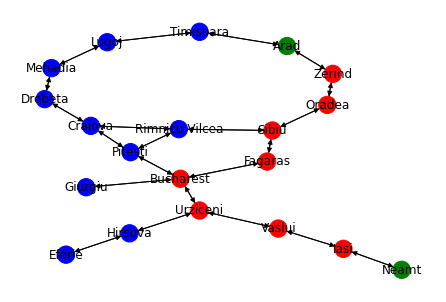

In [28]:
romania_navigation_problem = SimpleGraphProblem(romania, "Arad", "Neamt")

%time actions = breadth_first_search(romania_navigation_problem)
display_path(romania, romania_navigation_problem, actions)

In [29]:
# uniform_cost_search
def uniform_cost_search(problem):
    node = Node(state=problem.initial, path_cost=0)
    
    if problem.is_goal(node.state):
        return solution(node)
    
    frontier = PriorityQueue()
    frontier.put((0, node))
    
    explored = set()
    
    while not frontier.empty():
        node = frontier.get()[1]
        explored.add(node.state)
        
        for action in problem.get_actions(node.state):
            child = child_node(problem, node, action)
            
            if not (child.state in explored or (child.path_cost, child) in frontier):
                if problem.is_goal(child.state):
                    return solution(child)
                
                frontier.put((child.path_cost, child))
                
    return False

CPU times: user 204 µs, sys: 0 ns, total: 204 µs
Wall time: 206 µs
Node(Zerind) -> Node(Oradea) -> Node(Sibiu) -> Node(Rimnicu Vilcea) -> Node(Pitesti) -> Node(Bucharest) -> Node(Urziceni) -> Node(Vaslui) -> Node(Iasi) -> Node(Neamt)


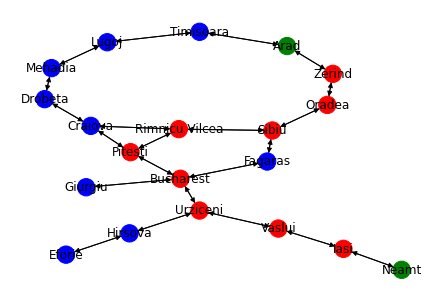

In [30]:
%time actions = uniform_cost_search(romania_navigation_problem)
display_path(romania, romania_navigation_problem, actions)

In [31]:
def depth_first_search(problem):
    node = Node(state=problem.initial, path_cost=0)
    
    if problem.is_goal(node.state):
        return solution(node)
    
    frontier = LifoQueue()
    frontier.put(node)
    
    explored = set()
    
    while not frontier.empty():
        node = frontier.get()
        explored.add(node.state)
        
        for action in problem.get_actions(node.state):
            child = child_node(problem, node, action)
            
            if not (child.state in explored or child in frontier):
                if problem.is_goal(child.state):
                    return solution(child)
                
                frontier.put(child)
                
    return False

CPU times: user 98 µs, sys: 23 µs, total: 121 µs
Wall time: 124 µs
Node(Timisoara) -> Node(Lugoj) -> Node(Mehadia) -> Node(Drobeta) -> Node(Craiova) -> Node(Pitesti) -> Node(Bucharest) -> Node(Urziceni) -> Node(Vaslui) -> Node(Iasi) -> Node(Neamt)


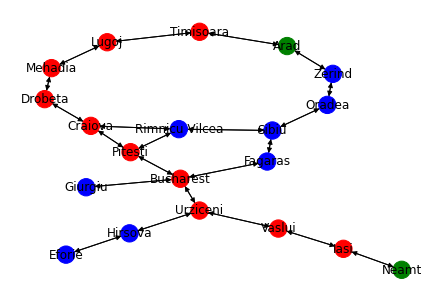

In [32]:
%time actions = depth_first_search(romania_navigation_problem)
display_path(romania, romania_navigation_problem, actions)

In [33]:
def depth_limited_search(problem, limit):
    return recursive_dls(
        Node(state=problem.initial, path_cost=0),
        problem,
        limit,
    )

def recursive_dls(node, problem, limit):
    if problem.is_goal(node.state):
        return solution(node)
    elif limit == 0:
        return "cutoff"
    else:
        cutoff = False
        
        for action in problem.get_actions(node.state):
            child = child_node(problem, node, action)
            result = recursive_dls(child, problem, limit-1)
            
            if result == "cutoff":
                cutoff = True
            elif result != False:
                return result
        
        if cutoff:
            return "cutoff"
        else:
            return False

In [35]:
%time actions = depth_limited_search(romania_navigation_problem,8)
display_path(romania, romania_navigation_problem, actions)

CPU times: user 626 µs, sys: 134 µs, total: 760 µs
Wall time: 762 µs
actions -> cutoff


In [19]:
# This one isn't in the book but I thought it could be fun -- it's basically uniform-cost search in reverse.
def worst_first_search(problem):
    node = Node(state=problem.initial, path_cost=0)
    
    if problem.is_goal(node.state):
        return solution(node)
    
    frontier = PriorityQueue()
    frontier.put((0, node))
    
    explored = set()
    
    while not frontier.empty():
        node = frontier.get()[1]
        explored.add(node.state)
        
        for action in problem.get_actions(node.state):
            child = child_node(problem, node, action)
            
            if not (child.state in explored or (-child.path_cost, child) in frontier):
                if problem.is_goal(child.state):
                    return solution(child)
                
                frontier.put((-child.path_cost, child))
                
    return False

CPU times: user 149 µs, sys: 0 ns, total: 149 µs
Wall time: 160 µs
Node(Timisoara) -> Node(Lugoj) -> Node(Mehadia) -> Node(Drobeta) -> Node(Craiova) -> Node(Rimnicu Vilcea) -> Node(Pitesti) -> Node(Bucharest) -> Node(Urziceni) -> Node(Vaslui) -> Node(Iasi) -> Node(Neamt)


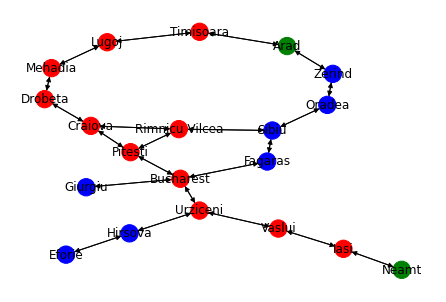

In [20]:
%time actions = worst_first_search(romania_navigation_problem)
display_path(romania, romania_navigation_problem, actions)

In [37]:
def iterative_deepening_search(problem, limit=None):
    depth = 0
    
    while True:
        if limit and depth > limit:
            return False
        
        result = depth_limited_search(problem, depth)
        
        if result != "cutoff":
            return result
        
        depth += 1

CPU times: user 4.04 ms, sys: 149 µs, total: 4.19 ms
Wall time: 4.16 ms
Node(Zerind) -> Node(Oradea) -> Node(Sibiu) -> Node(Fagaras) -> Node(Bucharest) -> Node(Urziceni) -> Node(Vaslui) -> Node(Iasi) -> Node(Neamt)


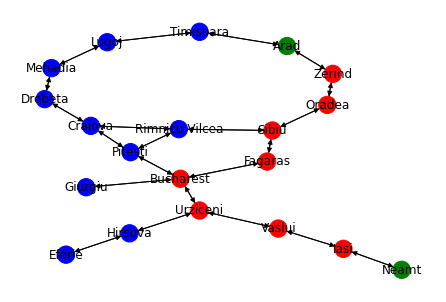

In [38]:
%time actions = iterative_deepening_search(romania_navigation_problem)
display_path(romania, romania_navigation_problem, actions)